In [13]:
import numpy as np
import astropy 
from astropy import constants as c
from astropy import units as u
import scipy.integrate as integrate
import matplotlib.pyplot as plt 

In [118]:
import numpy as np
# from scipy.integrate import trapz

# Constants
pi = np.pi

# Function to calculate B_v(T) (Planck function approximation)
def B_v(T, v):

    h = 6.626e-34  # Planck's constant (Joule-second)
    k = 1.381e-23  # Boltzmann constant (Joule/Kelvin)
    c = 3e8  # Speed of light (m/s) 
    

    return (2 * h * v**3 / c**2) / (np.exp(h * v / (k * T)) - 1)

# Function to calculate tau_v
def tau_v(kappa_0, v, v_0, beta, Sigma):
    return kappa_0 * (v / v_0)**beta * Sigma

# Function to calculate the integrand B_v(T) * (1 - exp(-tau_v))
def integrand(r, T0, v, kappa_0, v_0, beta, Sigma_function):

    ## in grams / cm^2
    Sigma_r = Sigma_function(r)

    ## dimensionless
    tau = tau_v(kappa_0, v, v_0, beta, Sigma_r)

    # in kelvin
    temp = T0 * (r)**(-3/7)

    Bv  =  B_v(temp, v)

    Bv_scaled_to_au = Bv * (1/6.68459e-12)**2

    return Bv_scaled_to_au * (1 - np.exp(-tau)) * 2 * pi * r

# Define Sigma(r) as a simple function of r (e.g., power law or exponential decay)
def Sigma_function(r, A1=3, sigma1=15, A2=.2, r_bump=100, sigma2=8):
    gaussian1 = A1 * np.exp(-r**2 / (2 * sigma1**2))
    gaussian2 = A2 * np.exp(-(r - r_bump)**2 / (2 * sigma2**2))
    baseline = 10**(-2)

    return gaussian1 + gaussian2 + baseline

# Main function to compute S_v
def S_v(i, d, R, T0, v, kappa_0, v_0, beta, Sigma_function, num_points=1000):
    """
    Compute S_v using the given parameters.

    Parameters:
    - i: inclination angle (radians)
    - d: distance (units consistent with R)
    - R: radius of integration limit
    - T: temperature (Kelvin)
    - v: frequency (Hz)
    - kappa_0: opacity coefficient at v_0
    - v_0: reference frequency (Hz)
    - beta: frequency exponent for opacity
    - Sigma_function: function defining Sigma(r) (surface density)
    - num_points: number of integration points

    Returns:
    - S_v: spectral intensity
    """
    sigma_func = lambda r: Sigma_function(r)
    integrand_func = lambda r: integrand(r, T0, v, kappa_0, v_0, beta, sigma_func)
    
    # Use quad for integration over r from 0 to R
    integral, error = integrate.quad(integrand_func, 0, R)
    
    cos_i = np.cos(i)
    return (cos_i / d**2) * integral

Text(0, 0.5, '$\\Sigma$ [g cm^(-2)]')

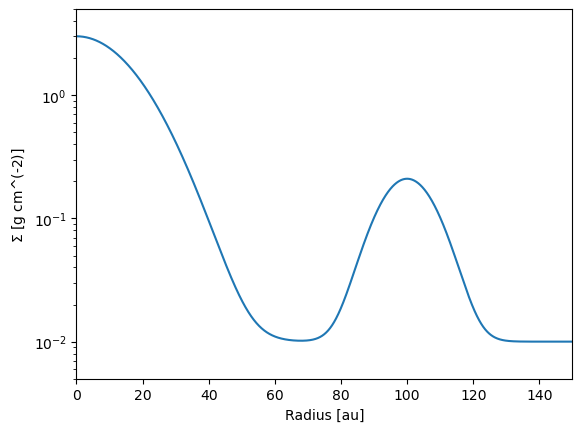

In [78]:
r = np.arange(0,150,.1)
plt.plot(r, Sigma_function(r))
plt.yscale('log')
plt.ylim(5*10**(-3),5)
plt.xlim(0,150)
plt.xlabel('Radius [au]')
plt.ylabel(r'$\Sigma$ [g cm^(-2)]')

In [122]:

# Example usage
if __name__ == "__main__":
    # Example parameters
    i = np.radians(45)  # 45 degrees inclination
    d = 450 * 9.461e+15  # Distance in meters
    L_star = 10 # in solar lums
    M_star = 2 # in solar mass


    R = 100  # Radius limit in arbitrary units
    T0 = 82 * (L_star/0.28)**(2/7) / (M_star/0.8)**(1/7)  # Temperature in Kelvin



    v_0 = 33*10**9  # Reference frequency in Hz

    # tunable parameters
    kappa_0 = 0.6  # Opacity coefficient at v_0
    beta = 1.4 # Opacity exponent

    # vs in Hz
    vs = np.arange(1*10**9,100*10**9,.1*10**9)
    Sv = []

    for v in vs:
        # Compute S_v
        S_v_value = S_v(i, d, R, T0, v, kappa_0, v_0, beta, Sigma_function)

        ## convert to microjansky
        S_v_value = S_v_value / 10**(-32)


        Sv.append(S_v_value)


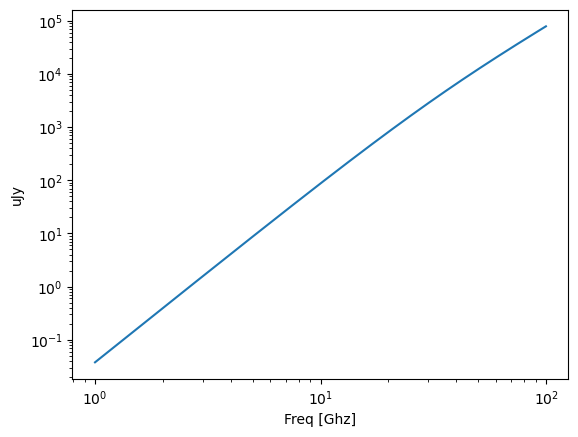

In [124]:
plt.plot(vs/(10**9), Sv)
# plt.plot(vs, 10**(-36)*vs**2)
# plt.plot(vs, 10**(-50)*vs**3.5)
plt.xlabel("Freq [Ghz]")
plt.ylabel("uJy")

plt.xscale('log')
plt.yscale('log')